# Auto Land Examples 4.6-2 & 4.6-4

In [ ]:
import sys
sys.path.append('../')
from tools.lin_transport import get_lin_transport
import control as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## 4.6-2

In [2]:
RTOD = 57.296
# Constants
Vt = 250  # ft/s
alpha = 2.0/RTOD  # rad
gamma = -2.5/RTOD  # rad
theta = alpha + gamma  # rad
altitude = 50 # ft
x_Earth = 0  # ft
X0 = [Vt, alpha, theta, 0, altitude, x_Earth]
thtl = 0.2  # throttle 0-1
elev = -2.0  # deg
U0 = [thtl, elev]

sys = get_lin_transport(X0, U0, gamma, land=True)

[-3.23850654e-04  3.13233191e-01 -1.48975073e+01]
Trim results:
Cost = 1.35675313932555e-12
Keas (knots): 148.24
Alpha (deg): -0.02
Theta (deg): -2.52
Throttle (0-1): 0.31
Elevator (deg): -14.90


In [3]:
keep = range(4)
ap = sys.A[keep][:,keep]
bp = sys.B[keep][:,[1]]
cp = sys.C[[2,3]][:,keep]
dp = sys.D[[2,3]][:,[1]]
plant = ct.ss(ap, bp, cp, dp)
plant

<LinearIOSystem:sys[3]:['u[0]']->['y[0]', 'y[1]']>

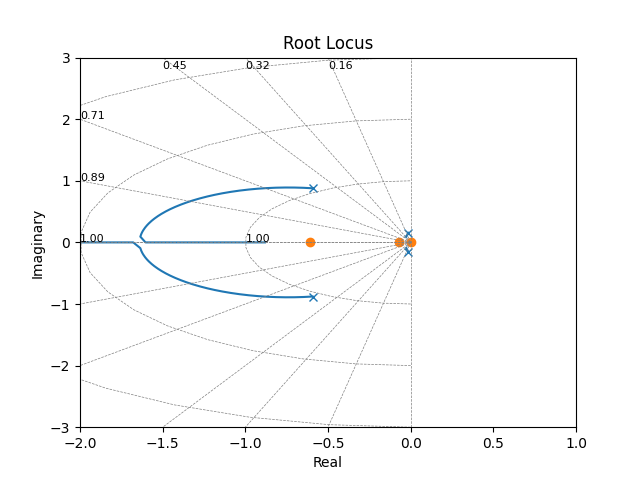

In [4]:
sysa = ct.ss([-10],[10],[-1],[0])
sys1 = ct.series(sysa, plant)
plt.figure()
%matplotlib widget
ct.root_locus(sys1[1,0],kvect=np.linspace(0,5,500),xlim=[-2,1],ylim=[-3,3],grid=True)
plt.show()

In [5]:
k_q = 1
acl = sys1.A - sys1.B @ np.array([[0, k_q]]) @ sys1.C
sys_q_cl = ct.ss(acl, sys1.B, sys1.C, sys1.D)
zeros = ct.zeros(sys_q_cl[0,0])
poles = ct.poles(sys_q_cl[0,0])

print("Zeros = ", zeros)
print("Poles = ", poles)

Zeros =  [-0.61105949+0.j -0.0732284 +0.j]
Poles =  [-9.28825399+0.j         -0.94416724+0.8673729j  -0.94416724-0.8673729j
 -0.01834732+0.13307001j -0.01834732-0.13307001j]


#### Check Theta root locus

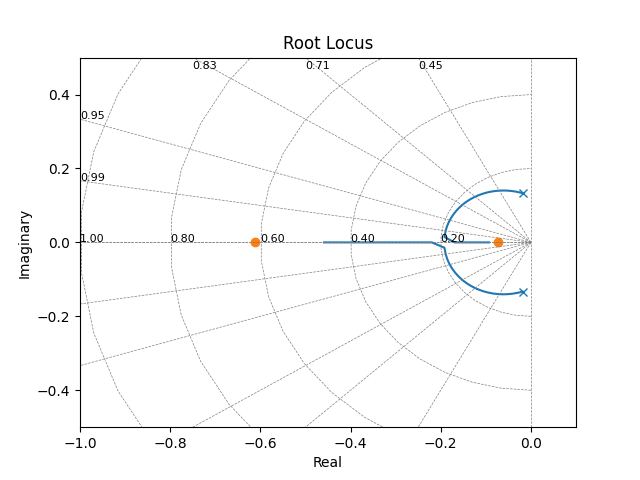

In [6]:
%matplotlib widget
plt.figure()
ct.root_locus(sys_q_cl[0,0], kvect = np.linspace(0,5,100), xlim=[-1, 0.1], ylim=[-.5, .5], grid=True)
plt.show()

#### Above damps the phugoid mode well, but has substantial steady state error
#### Add a PI compensator and find the best location of the PI zero

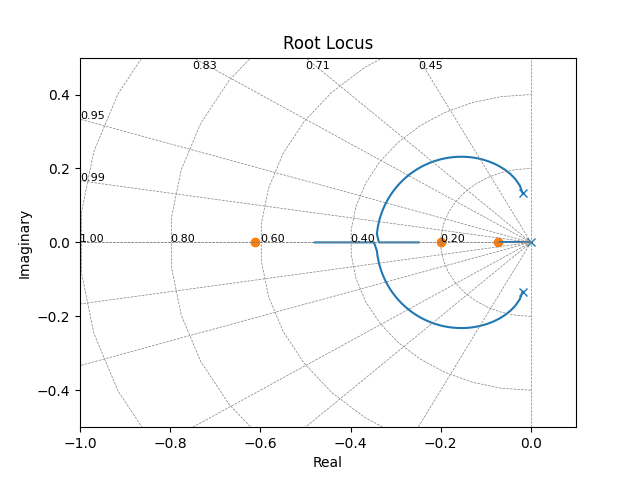

In [7]:
G_PI_zero = 0.2
sys_PI = ct.ss([0], [G_PI_zero], [1], [1])
sys_PI_q_cl = ct.series(sys_PI, sys_q_cl)

plt.figure()
ct.root_locus(sys_PI_q_cl[0,0], kvect = np.linspace(0,10,100), xlim=[-1, 0.1], ylim=[-.5, .5], grid=True)
plt.show()

#### Choose kp_theta = 2

In [8]:
kp_theta = 2
acl_PI = sys_PI_q_cl.A - sys_PI_q_cl.B @ np.array([[kp_theta, 0]]) @ sys_PI_q_cl.C
sys_theta_PI_cl_q_cl = ct.ss(acl_PI, sys_PI_q_cl.B * kp_theta, sys_PI_q_cl.C, sys_PI_q_cl.D)

#### Plot step response

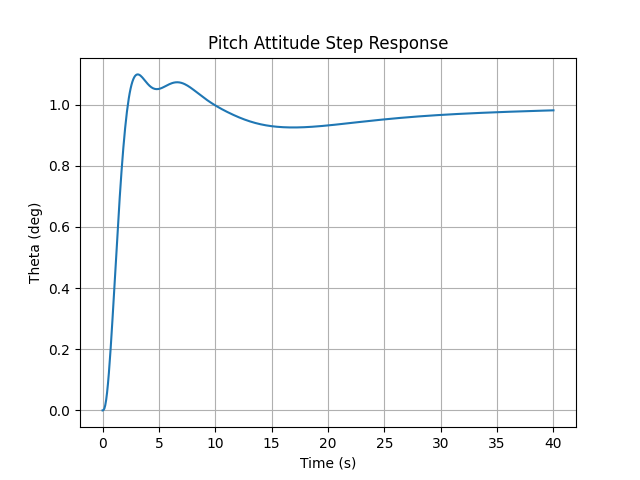

In [9]:
plt.figure()
t, y = ct.step_response(sys_theta_PI_cl_q_cl[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.grid()
plt.show()

In [10]:
lead_zero = 1.4
lead_pole = 14
lead_comp = ct.ss([-lead_pole],[1],[lead_zero-lead_pole],[1])
ct.ss2tf(lead_comp)

TransferFunction(array([1. , 1.4]), array([ 1., 14.]))

#### Use the above compensator and remove proportional gain

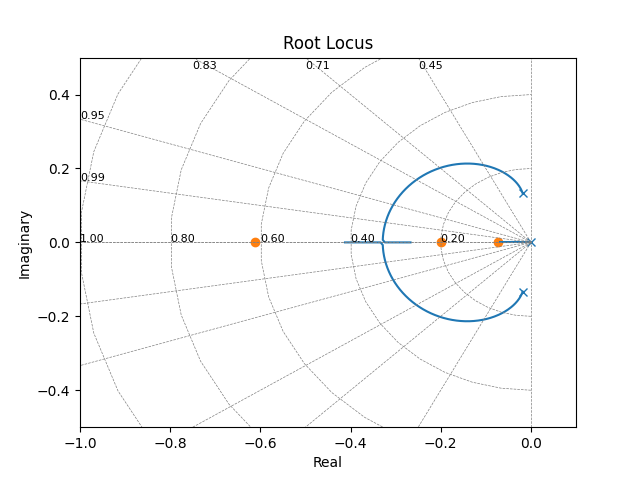

In [11]:
sys_lead_PI_q_cl = ct.series(lead_comp, sys_PI_q_cl)
plt.figure()
ct.root_locus(sys_lead_PI_q_cl[0,0], kvect = np.linspace(0,100,500), xlim=[-1, 0.1], ylim=[-.5, .5], grid=True)
plt.show()

In [12]:
lead_gain = 40
acl_lead = sys_lead_PI_q_cl.A - sys_lead_PI_q_cl.B @ np.array([[lead_gain, 0]]) @ sys_lead_PI_q_cl.C
sys_lead_PI_cl_q_cl = ct.ss(acl_lead,sys_lead_PI_q_cl.B * lead_gain,sys_lead_PI_q_cl.C,sys_lead_PI_q_cl.D)
lag_pole = 0.5
lag_zero = 2
sys_w_lag = ct.series(ct.ss(-lag_pole,lag_pole/lag_zero,lag_zero-lag_pole,lag_pole/lag_zero),sys_lead_PI_cl_q_cl)
zeros = ct.zeros(sys_w_lag[0,0])
poles = ct.poles(sys_w_lag[0,0])

print("Zeros = ", zeros)
print("Poles = ", poles)

Zeros =  [-2.00000000e+00+0.j  4.82133566e+16+0.j -1.40000000e+00+0.j
 -2.00000000e-01+0.j -7.32284022e-02+0.j -6.11059490e-01+0.j]
Poles =  [-16.193498  +0.j          -4.17001056+0.j
  -2.12150866+1.7621461j   -2.12150866-1.7621461j
  -0.27165164+0.15183728j  -0.27165164-0.15183728j
  -0.06345396+0.j          -0.5       +0.j        ]


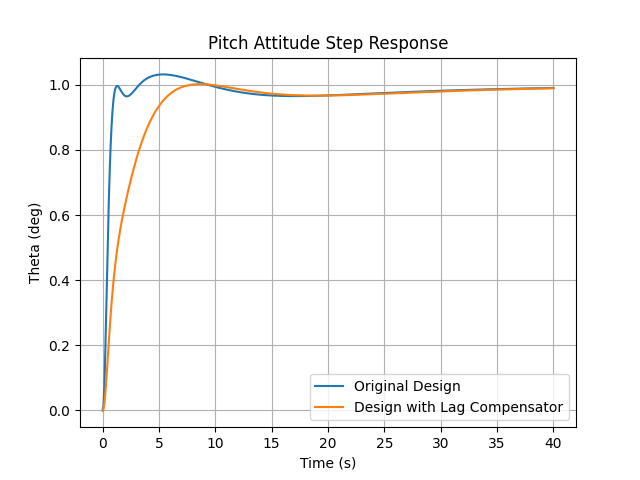

In [13]:
plt.figure()
t, y = ct.step_response(sys_lead_PI_cl_q_cl[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
t, y = ct.step_response(sys_w_lag[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.legend(['Original Design','Design with Lag Compensator'])
plt.grid()
plt.show()

#### Use Figure 3.9-9 Design to remove Kp zero (s + 0.2)

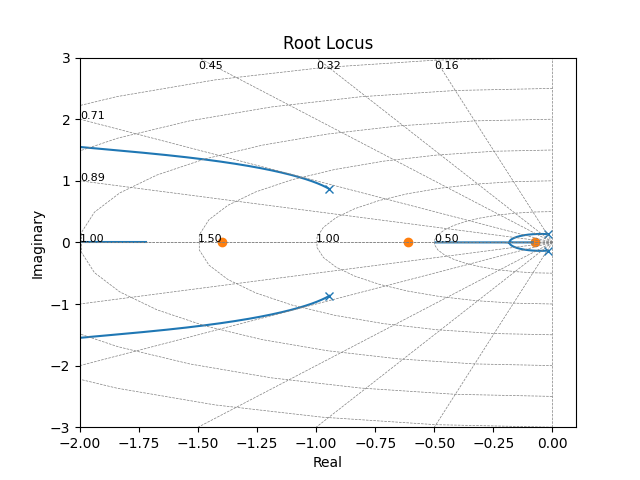

In [14]:
sys_lead_q = ct.series(lead_comp, sys_q_cl)
plt.figure()
ct.root_locus(sys_lead_q[0,0], kvect = np.linspace(0,100,500), xlim=[-2, 0.1], ylim=[-3, 3], grid=True)
plt.show()

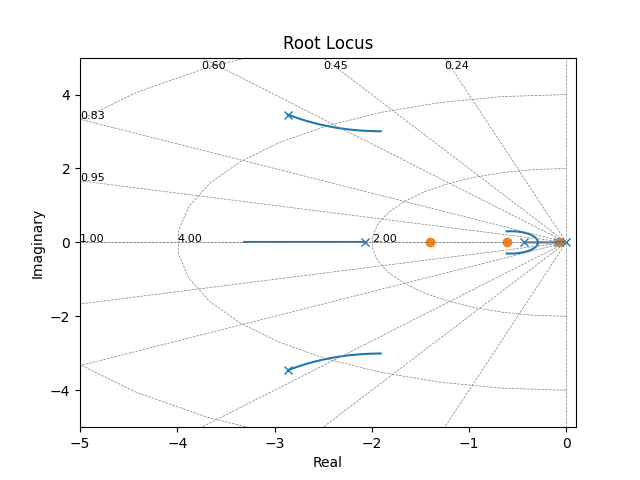

In [15]:
lead_gain = 60
acl_inner_P = sys_lead_q.A - sys_lead_q.B @ np.array([[lead_gain, 0]]) @ sys_lead_q.C
sys_lead_q_cl = ct.ss(acl_inner_P, sys_lead_q.B, sys_lead_q.C, sys_lead_q.D)
int_zero = 0.6
sys_int = ct.ss(0, int_zero, 1, 0)
sys_int_lead_q = ct.series(sys_int, sys_lead_q_cl)

plt.figure()
ct.root_locus(sys_int_lead_q[0,0], kvect = np.linspace(0,100,500), xlim=[-5, 0.1], ylim=[-5, 5], grid=True)
plt.show()


#### Use k_i = 60 and check that Kp zero is removed

In [16]:
k_i = 60 # unity feedback
acl_outer_I = sys_int_lead_q.A - sys_int_lead_q.B @ np.array([[k_i, 0]]) @ sys_int_lead_q.C
sys_no_P_zero = ct.ss(acl_outer_I, sys_int_lead_q.B * k_i, sys_int_lead_q.C, sys_int_lead_q.D)

zeros = ct.zeros(sys_no_P_zero[0,0])
poles = ct.poles(sys_no_P_zero[0,0])

print("Zeros = ", zeros)
print("Poles = ", poles)

Zeros =  [-1.4       +0.j -0.0732284 +0.j -0.61105949+0.j]
Poles =  [-16.83148947+0.j          -2.36911769+3.10476913j
  -2.36911769-3.10476913j  -2.64391804+0.j
  -0.46419683+0.27971078j  -0.46419683-0.27971078j
  -0.07124656+0.j        ]


#### Compare Step Response

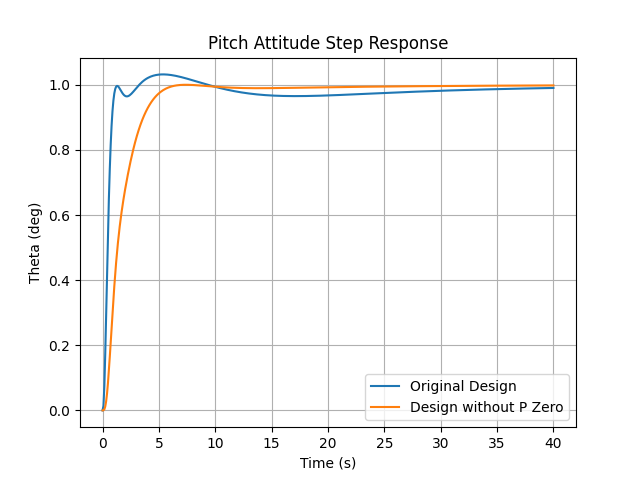

In [17]:
plt.figure()
t, y = ct.step_response(sys_lead_PI_cl_q_cl[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
t, y = ct.step_response(sys_no_P_zero[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.legend(['Original Design','Design without P Zero'])
plt.grid()
plt.show()

#### Compare Margins

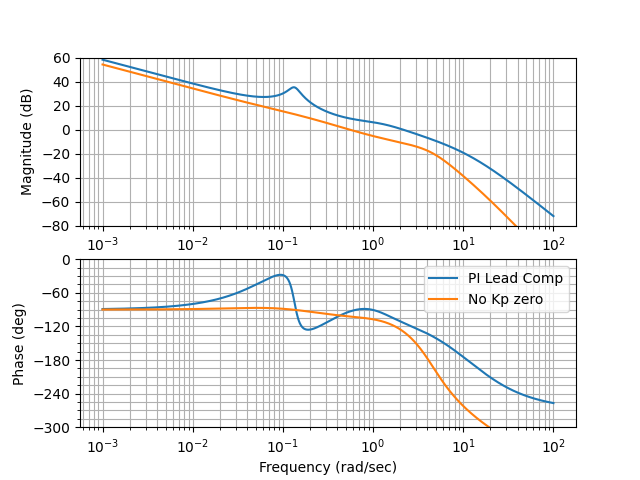

In [18]:
plt.figure()
mag, ph, f = ct.bode_plot(40*sys_lead_PI_q_cl[0,0], omega=np.logspace(-3,2,1000), dB=True)
mag, ph, f = ct.bode_plot(60*sys_int_lead_q[0,0], omega=np.logspace(-3,2,1000), dB=True)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-80,80,20))
plt.ylim([-80,60])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-300,60,60))
plt.ylim([-300,0])
lg = plt.legend(['PI Lead Comp','No Kp zero'])

## 4.6-4

In [19]:
RTOD = 57.296
# Constants
Vt = 250  # ft/s
alpha = 2.0/RTOD  # rad
gamma = -2.5/RTOD  # rad
theta = alpha + gamma  # rad
altitude = 750 # ft
x_Earth = 0  # ft
delta_r = 0 # ft - distance from desired flight path
X0 = [Vt, alpha, theta, 0, altitude, x_Earth, delta_r]
thtl = 0.2  # throttle 0-1
elev = -2.0  # deg
gamma_r = -2.5/RTOD # rad
U0 = [thtl, elev, gamma_r]
sys = get_lin_transport(X0, U0, gamma, land=True)

[ 3.82317750e-03  3.09434224e-01 -1.52184187e+01]
Trim results:
Cost = 1.308524433254141e-12
Keas (knots): 146.73
Alpha (deg): 0.22
Theta (deg): -2.28
Throttle (0-1): 0.31
Elevator (deg): -15.22


In [20]:
keep = [0,1,2,3,4,6]
out_idx = [0,2,3,6]
ap = sys.A[keep][:,keep]
bp = sys.B[keep][:,[0,1]]
cp = sys.C[out_idx][:,keep]
dp = sys.D[out_idx][:,[0,1]]
plant = ct.ss(ap, bp, cp, dp)
plant

<LinearIOSystem:sys[63]:['u[0]', 'u[1]']->['y[0]', 'y[1]', 'y[2]', 'y[3]']>

In [21]:
zeros = ct.zeros(plant[1,1])
poles = ct.poles(plant[1,1])

print("Zeros = ", zeros)
print("Poles = ", poles)

Zeros =  [ 0.00000000e+00+0.j -5.95656003e-01+0.j -7.52638137e-02+0.j
 -1.96450050e-04+0.j]
Poles =  [ 0.00000000e+00+0.j         -5.81493974e-01+0.8709007j
 -5.81493974e-01-0.8709007j  -1.31045585e-02+0.15854637j
 -1.31045585e-02-0.15854637j -2.16482823e-04+0.j        ]


In [22]:
sysa = ct.ss([-10],[10],[-1],[0])
sys_pitch = ct.series(sysa, ct.ss(plant.A, plant.B[:,[1]], plant.C[[1,2]], plant.D[[1,2]][:,[1]]))

k_q = 1
acl = sys_pitch.A - sys_pitch.B @ np.array([[0, k_q]]) @ sys_pitch.C
sys_q_cl = ct.ss(acl, sys_pitch.B, sys_pitch.C, sys_pitch.D)

#### Use the same lead compensator

In [23]:
lead_pole = 14
lead_zero = 1.4
lead_comp = ct.ss(-lead_pole, lead_pole, (lead_zero - lead_pole)/lead_pole, 1)
ct.ss2tf(lead_comp)

TransferFunction(array([1. , 1.4]), array([ 1., 14.]))

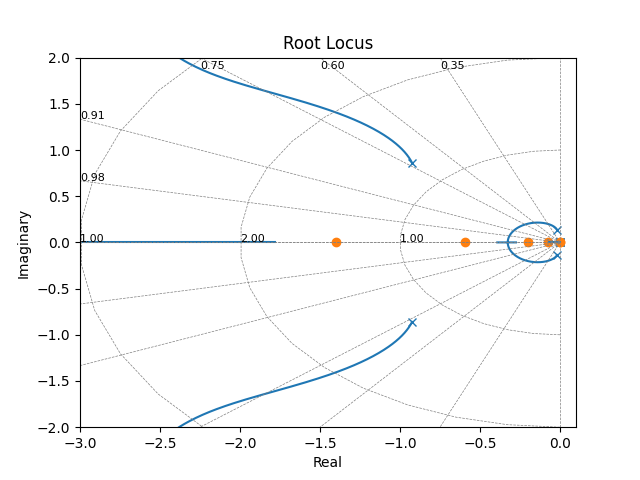

In [24]:
sys_lead = ct.series(lead_comp, sys_q_cl)

G_pi_zero = 0.2
G_pi = ct.ss(0, G_pi_zero, 1, 1)

sys_pitch_ol = ct.series(G_pi, sys_lead)
B_t = sys_pitch_ol.B

plt.figure()
ct.root_locus(sys_pitch_ol[0,0], kvect = np.linspace(0,100,500), xlim=[-3, 0.1], ylim=[-2, 2], grid=True)
plt.show()

In [25]:
K = 40
acl_pitch = sys_pitch_ol.A - B_t @ np.array([[K]]) @ sys_pitch_ol.C[[0]]
sys_pitch_cl = ct.ss(acl_pitch, B_t * K, sys_pitch_ol.C[[0]], 0)

zeros = ct.zeros(sys_pitch_cl)
poles = ct.poles(sys_pitch_cl)

print("Zeros = ", zeros)
print("Poles = ", poles)

Zeros =  [ 0.00000000e+00+0.j -1.40000000e+00+0.j -2.00000000e-01+0.j
 -5.95656003e-01+0.j -7.52638137e-02+0.j -1.96450050e-04+0.j]
Poles =  [ 0.00000000e+00+0.j         -1.61637115e+01+0.j
 -4.38443952e+00+0.j         -2.02086761e+00+1.73024428j
 -2.02086761e+00-1.73024428j -2.67366517e-01+0.15537782j
 -2.67366517e-01-0.15537782j -6.45978097e-02+0.j
 -1.96445096e-04+0.j        ]


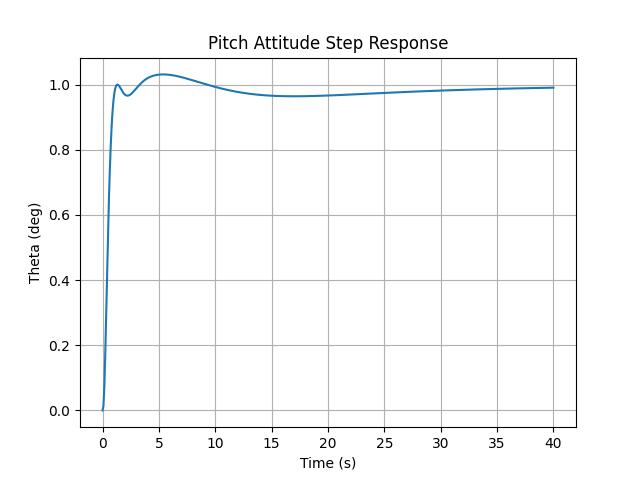

In [26]:
plt.figure()
t, y = ct.step_response(sys_pitch_cl[0,0], T=np.linspace(0,40,500))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.grid()
plt.show()

In [27]:
sys_pitch_cl

<LinearIOSystem:sys[81]:['u[0]']->['y[0]']>

In [28]:
C_Vt = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0]])
B_thtl = np.c_[np.append(np.array([[0],[0],[0]]),plant.B[:,[0]])]
plant_Vt = ct.ss(acl_pitch, B_thtl, C_Vt, 0)

zeros = ct.zeros(plant_Vt)
poles = ct.poles(plant_Vt)

print("Zeros = ", zeros)
print("Poles = ", poles)
print(ct.ss2tf(plant_Vt))

Zeros =  [ 0.00000000e+00+0.j         -1.61638792e+01+0.j
 -4.37148069e+00+0.j         -2.03323802e+00+1.71815645j
 -2.03323802e+00-1.71815645j -2.73611062e-01+0.11153365j
 -2.73611062e-01-0.11153365j -1.48555255e-03+0.j        ]
Poles =  [ 0.00000000e+00+0.j         -1.61637115e+01+0.j
 -4.38443952e+00+0.j         -2.02086761e+00+1.73024428j
 -2.02086761e+00-1.73024428j -2.67366517e-01+0.15537782j
 -2.67366517e-01-0.15537782j -6.45978097e-02+0.j
 -1.96445096e-04+0.j        ]

       10.1 s^8 + 254 s^7 + 1766 s^6 + 5287 s^5 + 7599 s^4 + 3160 s^3 + 446.2 s^2 + 0.6559 s
---------------------------------------------------------------------------------------------------
s^9 + 25.19 s^8 + 175.9 s^7 + 531.6 s^6 + 781.6 s^5 + 358 s^4 + 68.03 s^3 + 3.112 s^2 + 0.0006087 s



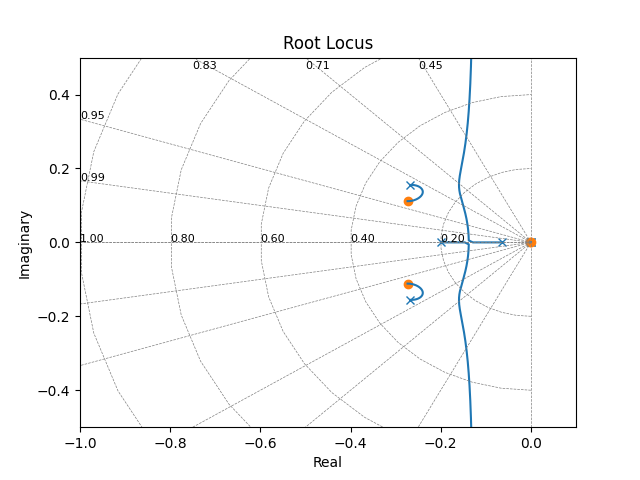

In [29]:
thtl_T = 0.2
sys_thtl = ct.ss(-thtl_T,thtl_T,1,0)

sys_Vt_ol = ct.series(sys_thtl, plant_Vt)
plt.figure()
ct.root_locus(sys_Vt_ol[0,0], kvect = np.logspace(-4,1,500), xlim=[-1, 0.1], ylim=[-.5, .5], grid=True)
plt.show()

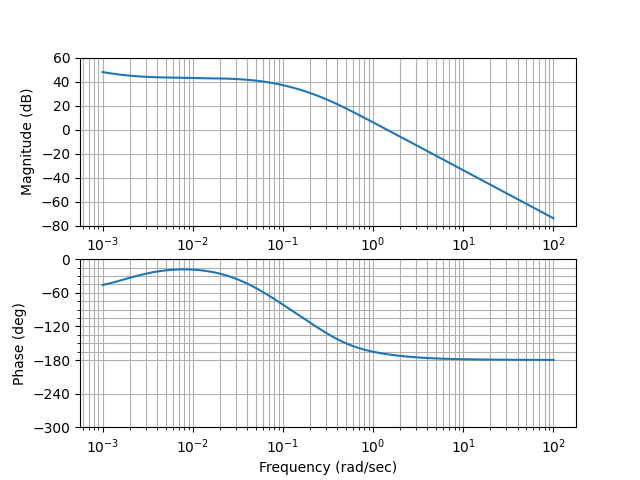

In [30]:
plt.figure()
mag, ph, f = ct.bode_plot(sys_Vt_ol, omega=np.logspace(-3,2,1000), dB=True)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-80,80,20))
plt.ylim([-80,60])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-300,60,60))
plt.ylim([-300,0])
plt.show()

In [31]:
G1_zero = 1
G1_pole = 10
G1_lead = ct.ss(-G1_pole,1,G1_zero-G1_pole,1)
ct.ss2tf(G1_lead)

TransferFunction(array([1., 1.]), array([ 1., 10.]))

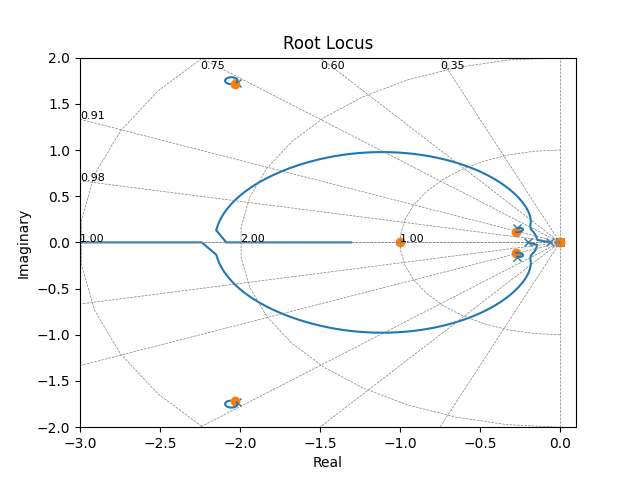

In [32]:
sys_ut2vt = ct.series(G1_lead, sys_Vt_ol)
plt.figure()
ct.root_locus(sys_ut2vt[0,0], kvect = np.linspace(0,20,500), xlim=[-3, 0.1], ylim=[-2, 2], grid=True)
plt.show()

#### Close the d/theta_c loop

In [33]:
acl_vc2vt = sys_ut2vt.A - sys_ut2vt.B @ np.array([[10]]) @ sys_ut2vt.C
B_theta = np.c_[np.append(np.array([[0],[0]]), B_t * 40)]
C_d = np.zeros([1,11])
C_d[0][10] = 1
dc_thetac = ct.ss(acl_vc2vt, B_theta, C_d, 0)

zeros = ct.zeros(dc_thetac)
poles = ct.poles(dc_thetac)

print("Zeros = ", zeros)
print("Poles = ", poles)
print(ct.ss2tf(dc_thetac))

Zeros =  [ 3.74636036e+04+0.00000000e+00j -7.98508821e+03+3.86017684e+04j
 -7.98508821e+03-3.86017684e+04j -6.07841053e+04+0.00000000e+00j
 -7.63223267e+00+0.00000000e+00j -1.29233292e+00+9.90861303e-01j
 -1.29233292e+00-9.90861303e-01j -1.40000000e+00+0.00000000e+00j
 -2.31019147e-07+0.00000000e+00j -2.00000000e-01+0.00000000e+00j]
Poles =  [ 0.00000000e+00+0.j         -1.61637386e+01+0.j
 -7.62359922e+00+0.j         -4.40994932e+00+0.j
 -2.02083413e+00+1.76998095j -2.02083413e+00-1.76998095j
 -1.30196328e+00+0.95938512j -1.30196328e+00-0.95938512j
 -2.72527358e-01+0.11137386j -2.72527358e-01-0.11137386j
 -1.47681672e-03+0.j        ]

3.553e-14 s^10 + 4.547e-13 s^9 + 1.819e-12 s^8 + 2.444e-05 s^7 + 675.2 s^6 + 7979 s^5 + 2.634e+04 s^4 + 3.977e+04 s^3 + 2.61e+04 s^2 + 3826 s + 0.000884
--------------------------------------------------------------------------------------------------------------------------------------------------------
         s^11 + 35.39 s^10 + 455 s^9 + 2904 s^8 + 

#### Root locus

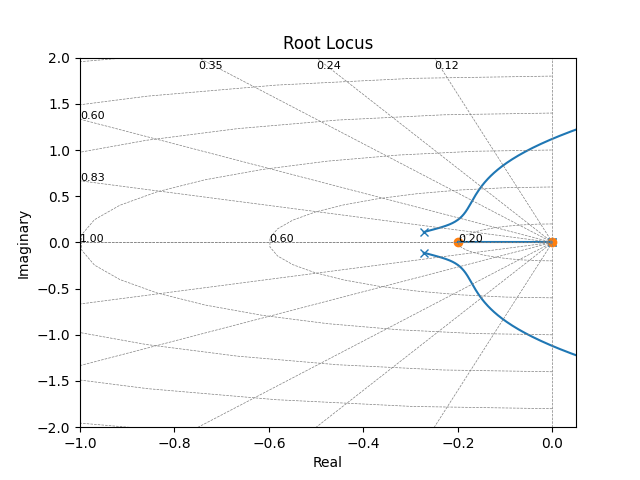

In [34]:
plt.figure()
ct.root_locus(dc_thetac, kvect = np.logspace(-4,2,500), xlim=[-1, 0.05], ylim=[-2, 2], grid=True)
plt.show()

#### Check d/theta_c margins

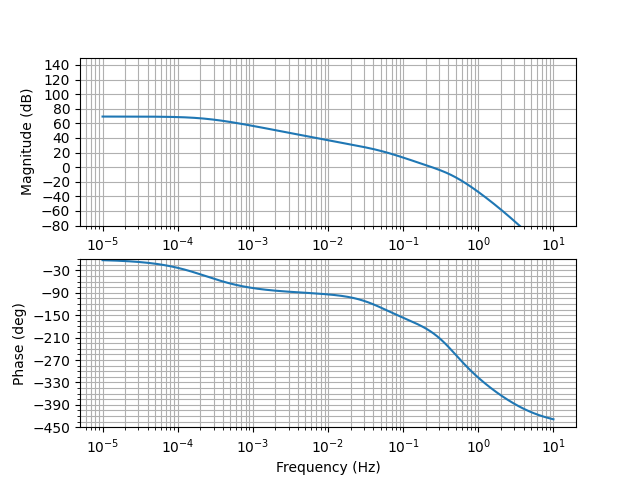

In [35]:
plt.figure()
mag, ph, f = ct.bode_plot(dc_thetac, Hz=True, omega=np.logspace(-5,1,1000)*(2*3.1416), dB=True)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-80,170,20))
plt.ylim([-80,150])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-450,60,60))
plt.ylim([-450,0])
plt.show()

In [36]:
G_2_lead = ct.ss(-5, 5, -0.9, 1)
ct.ss2tf(G_2_lead)

TransferFunction(array([1. , 0.5]), array([1., 5.]))

In [37]:
G_2_pi = ct.ss(0,0.18,1,1)

G_2_c = ct.series(G_2_lead, G_2_pi)

sys_d2ed = ct.series(G_2_c, dc_thetac)

#### Plot Bode to check margins

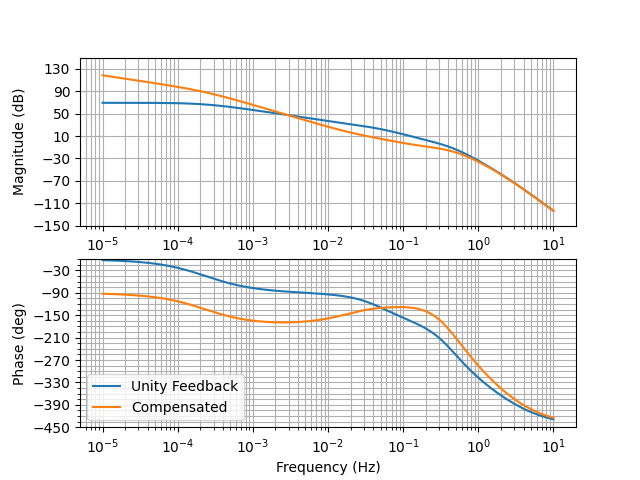

In [38]:
plt.figure()
mag, ph, f = ct.bode_plot(dc_thetac, Hz=True, omega=np.logspace(-5,1,1000)*(2*3.1416), dB=True)
mag, ph, f = ct.bode_plot(sys_d2ed, Hz=True, omega=np.logspace(-5,1,1000)*(2*3.1416), dB=True)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-150,170,40))
plt.ylim([-150,150])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-450,60,60))
plt.ylim([-450,0])
plt.legend(['Unity Feedback','Compensated'])
plt.show()

#### Inspect d/d_c transfer function

In [39]:
acl_dc2d = sys_d2ed.A - sys_d2ed.B @ np.array([[1]]) @ sys_d2ed.C
sys_dc2d = ct.ss(acl_dc2d, sys_d2ed.B, sys_d2ed.C, 0)

zeros = ct.zeros(sys_dc2d)
poles = ct.poles(sys_dc2d)

print("Zeros = ", zeros)
print("Poles = ", poles)
print(ct.ss2tf(sys_dc2d))

Zeros =  [-5.00000000e-01+0.00000000e+00j -9.13258751e+00+1.02305013e+09j
 -9.13258751e+00-1.02305013e+09j -2.00000000e-01+0.00000000e+00j
 -1.80000000e-01+0.00000000e+00j -2.76243207e+07+0.00000000e+00j
 -7.63223267e+00+0.00000000e+00j -1.40000000e+00+0.00000000e+00j
 -2.31019774e-07+0.00000000e+00j -1.29233292e+00+9.90861303e-01j
 -1.29233292e+00-9.90861303e-01j]
Poles =  [-1.61862488e+01+0.j         -7.62511247e+00+0.j
 -5.15545274e+00+1.64885786j -5.15545274e+00-1.64885786j
 -1.38404675e+00+1.69176894j -1.38404675e+00-1.69176894j
 -1.27784274e+00+0.94922359j -1.27784274e+00-0.94922359j
 -2.92197603e-01+0.34843189j -2.92197603e-01-0.34843189j
 -1.79486176e-01+0.07634887j -1.79486176e-01-0.07634887j
 -2.31019728e-07+0.j        ]

7.105e-15 s^12 + 1.137e-13 s^11 + 3.638e-12 s^10 + 2.444e-05 s^9 + 675.2 s^8 + 8438 s^7 + 3.182e+04 s^6 + 5.84e+04 s^5 + 5.551e+04 s^4 + 2.515e+04 s^3 + 4951 s^2 + 344.4 s + 7.956e-05
--------------------------------------------------------------------------

#### Inspect v_T/v_c transfer function

In [40]:
sys_vc2vt =  ct.ss(acl_vc2vt, sys_ut2vt.B * 10, sys_ut2vt.C, 0)

zeros = ct.zeros(sys_vc2vt)
poles = ct.poles(sys_vc2vt)

print("Zeros = ", zeros)
print("Poles = ", poles)
print(ct.ss2tf(sys_vc2vt))

Zeros =  [ 0.00000000e+00+0.j         -1.00000000e+00+0.j
 -1.61638792e+01+0.j         -4.37148069e+00+0.j
 -2.03323802e+00+1.71815645j -2.03323802e+00-1.71815645j
 -1.48555255e-03+0.j         -2.73611062e-01+0.11153365j
 -2.73611062e-01-0.11153365j]
Poles =  [ 0.00000000e+00+0.j         -1.61637386e+01+0.j
 -7.62359922e+00+0.j         -4.40994932e+00+0.j
 -2.02083413e+00+1.76998095j -2.02083413e+00-1.76998095j
 -1.30196328e+00+0.95938512j -1.30196328e+00-0.95938512j
 -2.72527358e-01+0.11137386j -2.72527358e-01-0.11137386j
 -1.47681672e-03+0.j        ]

  4.263e-14 s^10 + 20.2 s^9 + 528.2 s^8 + 4040 s^7 + 1.411e+04 s^6 + 2.577e+04 s^5 + 2.152e+04 s^4 + 7213 s^3 + 893.7 s^2 + 1.312 s
-------------------------------------------------------------------------------------------------------------------------------------
s^11 + 35.39 s^10 + 455 s^9 + 2904 s^8 + 1.06e+04 s^7 + 2.35e+04 s^6 + 3.106e+04 s^5 + 2.293e+04 s^4 + 7381 s^3 + 899.9 s^2 + 1.313 s

